# Jason Kunisaki - Quinlan Lab Rotation
## Evaluate CCRs

This notebook contains the script needed to recapitulate CCRs from the first iteration of CCRs [(see manuscript)](https://www.nature.com/articles/s41588-018-0294-6.epdf?author_access_token=N8RkVYcavtplcSSE2KJkNdRgN0jAjWel9jnR3ZoTv0OG-o3UTB17cpoBs8B6XMBCl-5E0ZvpOii0iPl_hRSMGjWfkG4em7gjy95eV4bkTb0AF-E_dj3obeJfaadTja3aj9hUh1xk_BIztWgJScFx8w%3D%3D) and develop new filter parameters to better define CCRs. These parameters include **VAF, SIFT/PolyPhen scores, and coverage**. Use [PathoScore](https://github.com/quinlan-lab/pathoscore) to determine the efficacy of CCRs as a classifier for clinvar pathogenic variants. SIFT and PolyPhen interpretations can be found in the [VEP annotation descriptions](https://uswest.ensembl.org/info/genome/variation/prediction/protein_function.html).   

## Import modules

In [2]:
import cyvcf2
import sys
import exter ## exter.py file has to be in the working directory 
import re
import pandas as pd
import numpy as np
from collections import defaultdict
from scipy.stats import percentileofscore
import subprocess
from IPython.display import SVG

## Define the gff and vcf file path 
gff_path = "/Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/reference/Homo_sapiens.GRCh37.82.chr20.gff3" 
vcf_path = "/Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/reference/gnomad.exomes.r2.1.1.sites.20.vcf.bgz"

## Define SIFT/PolyPhen filter parameters 
sift_polyphen_filter = True
sift_cutoff = 0.05
polyphen_cutoff = 0.446

## Assign the pathoscore key name 
pathoscore_name = "new_CCR"

## Assign test gene name 
test_key = "GNAS"

## Read through a VCF file and obtain all variants. This step requires the [cyvcf2](https://github.com/brentp/cyvcf2/tree/master/cyvcf2) function to read and process the vcf file. See comments for rationale. 

In [3]:
## Read in the VCF file 
vcf = cyvcf2.VCF(vcf_path)

## Function to identify functional mutations 
def isfunctional(csq):
    return any(c in csq['Consequence'] for c in ('stop_gained', 'stop_lost', 'start_lost', 
                                                 'initiator_codon_variant', 'rare_amino_acid_variant', 
                                                 'missense_variant', 'protein_altering_variant', 
                                                 'frameshift_variant', 'inframe_insertion', 'inframe_deletion')) \
    or (('splice_donor_variant' in csq['Consequence'] or 'splice_acceptor_variant' in csq['Consequence']) \
        and 'coding_sequence_variant' in csq['Consequence'])

## Get the VEP description fields into a 'list'
kcsq = vcf["vep"]["Description"].split(":")[1].strip(' "').split("|")

## Read in the gff transcript file and subset calls from chr20
transcripts = exter.read_gff(gff_path)
transcripts20 = transcripts["20"] # get chr20

## Make an empty dictionary 
local_by_gene = defaultdict(list)

## For each variant in the VCF file: 
for variant in vcf:
    ## Remove variants that have "None, PASS, SEGDUP, or LCR" as the filter result
    ## NOTE: 'continue' will remove variants without these FILTER results
    if not (variant.FILTER is None or variant.FILTER in ["PASS", "SEGDUP", "LCR"]):
            continue
    ## Get the variant 'INFO' field from the VCF file for each variant
    info = variant.INFO
    ## Set the functional consequence of the variant to 'False'
    any_functional = False
    ## Merge the kcsq description keys with 
    csqs = [dict(zip(kcsq, c.split("|"))) for c in info['vep'].split(",")]

    ## For all variant/consequences that are within protein_coding regions
    for csq in (c for c in csqs if c['BIOTYPE'] == 'protein_coding'):
        ## NOTE: 'continue' will ignore variants that are intronic 
        if csq['Feature'] == '' or csq['EXON'] == '': 
            continue #or csq['cDNA_position'] == '': continue
        ## Check to see if the variant's consequence is functional (based on the mutation types listed above)
        ## NOTE: 'continue' will ignore variants that are not functional
        if not isfunctional(csq): 
            continue
        ## Assigns True to the variant as functional if it is NOT intronic and is deemed as functional by the 'isfunctional' function
        any_functional = True

        ## Get the exonic positions of the variants
        local = transcripts20.localize(variant.start, variant.end)

        ## Get the VAF of the variant
        vaf = variant.INFO.get('AF')

        ## Get the SIFT/PolyPhen results (IS THIS RIGHT)
        SIFT = csq["SIFT"]
        PolyPhen = csq["PolyPhen"]
                
        ## Get the reference allele 
        ref_allele = variant.REF

        ## Get string for the mutation 
        mut = []
        for alt in variant.ALT: 
            mut.append(ref_allele + ">" + alt) 
        
        ## Remove variants that do not meet a specific VAF cutoff 
        # if vaf < 0.0000001: continue
        
        ## Perform SIFT and Polyphen filters to remove the least delterious/damaging variant(s)
        ## Go through each pair of scores and check if the varaint has SIFT and PolyPhen scores
        sift_score = sift_cutoff + 0.1
        polyphen_score = polyphen_cutoff - 0.1
        if sift_polyphen_filter == True: 
            if re.findall("deleterious", SIFT):
                sift_score = float(re.split('\)', re.split('\(', SIFT)[1])[0])
            if re.findall("damaging", PolyPhen):
                polyphen_score = float(re.split('\)', re.split('\(', PolyPhen)[1])[0])
            ## SIFT score has to be below the sift_cutoff to pass 
            ## PolyPhen score has to be above the polyphen_cutoff to pass 
            if not sift_score < sift_cutoff and polyphen_score > polyphen_cutoff:
                continue

        ## Remove variants that are found in duplicated segments 
        #if variant.INFO.get('segdup') == True or variant.INFO.get('lcr'): continue

        ## Get the chromosome 
        chr = variant.CHROM

        for l in local:
            l["chr"] = chr
            l["chr_start"] = variant.start
            l["chr_stop"] = variant.end
            l["mutation"] = mut
            l["vaf"] = vaf
            l["SIFT"] = sift_score
            l["PolyPhen"] = polyphen_score
            local_by_gene[l["gene"]].append(l)
        break

In [4]:
local_by_gene[test_key]

[{'gene': 'GNAS',
  'start': 0,
  'stop': 1,
  'strand': '+',
  'exon': 0,
  'chr': '20',
  'chr_start': 57415162,
  'chr_stop': 57415163,
  'mutation': ['T>A'],
  'vaf': 4.086170065420447e-06,
  'SIFT': 0.0,
  'PolyPhen': 0.537},
 {'gene': 'GNAS',
  'start': 0,
  'stop': 3,
  'strand': '+',
  'exon': 0,
  'chr': '20',
  'chr_start': 57415162,
  'chr_stop': 57415165,
  'mutation': ['TGG>T'],
  'vaf': 1.6344700270565227e-05,
  'SIFT': 0.15000000000000002,
  'PolyPhen': 0.346},
 {'gene': 'GNAS',
  'start': 3,
  'stop': 4,
  'strand': '+',
  'exon': 0,
  'chr': '20',
  'chr_start': 57415165,
  'chr_stop': 57415166,
  'mutation': ['A>AAT'],
  'vaf': 1.633280044188723e-05,
  'SIFT': 0.15000000000000002,
  'PolyPhen': 0.346},
 {'gene': 'GNAS',
  'start': 5,
  'stop': 6,
  'strand': '+',
  'exon': 0,
  'chr': '20',
  'chr_start': 57415167,
  'chr_stop': 57415168,
  'mutation': ['C>G'],
  'vaf': 0.00012254799366928637,
  'SIFT': 0.0,
  'PolyPhen': 0.913},
 {'gene': 'GNAS',
  'start': 5,
  'sto

## Perform quality check on pathogenic variants. Remove genes with no variants after applying filters (see above). 

In [5]:
final_variant_vcf = defaultdict(list)
## Check if there is at least one variant in each gene 
for key in local_by_gene.keys():
    if len(local_by_gene[key]) > 0:
        final_variant_vcf[key] = local_by_gene[key]

## Fix overlapping variants within each gene + apply SIFT/PolyPhen and VAF filters
| Position |   V1   |   V2   |   V3   |   V4   |   V5   |   V6   |   V7   |   V8   |   V9   |  V10   |
| :------- | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: | :----: |
| Start    | 126244 | 126244 | 126253 | 126255 | 126258 | 126258 | 126260 | 126264 | 126264 | 126265 | 
| End      | 126245 | 126254 | 126254 | 126256 | 126259 | 126262 | 126279 | 126265 | 126265 | 126266 | 

### Combine variant positions for:
+ adjacent bases 
+ equivalent variants (in terms of position) 
+ overlapping variants

### The determined variant range should encompass all of the above variants
| Position | window 1 | window 2 | window 3 |
| :------: | :------: | :------: | :------: |
| Start    | 126244   | 126255   | 126258   |
| End      | 126254   | 126256   | 126279   |

In [6]:
## Inititalize the master list 
unique_variant_pos_all_genes = defaultdict(list)
for key in final_variant_vcf.keys():
    subset_variants = final_variant_vcf[key]
    ## Get all of the start and stop variant positions within the gene
    start_positions = [d["chr_start"] for d in subset_variants]
    end_positions = [d["chr_stop"] for d in subset_variants]
    exonic_end_positions = [d["stop"] for d in subset_variants]

    ## Go throouh each start/end position and check if there are overlapping variants 
    unique_variant_pos_per_gene = []
    positions = []
    for start, end in zip(start_positions, end_positions):
        ## Get variants that have the same start/stop position 
        temp1 = list(filter(lambda subset_variants: 
               subset_variants["chr_start"] <= start and subset_variants["chr_stop"] >= start, subset_variants))
        ## Check to see if there are variants that overlap with the end position
        new_end = max([d["chr_stop"] for d in temp1])
        temp2 = list(filter(lambda subset_variants:
                   subset_variants["chr_start"] <= new_end and subset_variants["chr_stop"] >= new_end, subset_variants))
        ## Combine all variants that overlap with the intial variant in question
        for v in temp2: 
            if v not in temp1: 
                temp1.append(v)

        ## Get the index at which an adjacent variant's start position overlaps wtih the end position of the adjusted window
        ## Assign the maximum end pos of the adjacent variant as the window's stop position
        while max(set([d["chr_stop"] for d in temp1])) in start_positions and \
        max(set([d["chr_stop"] for d in temp1])) not in positions: ## Make sure it does not pull a variant that was already accounted for in a window
            d = defaultdict(list)
            for index, e in enumerate(start_positions):
                d[e].append(index)
            ## Get all the end positions of adjacent variants 
            end_index = d[max(set([d["chr_stop"] for d in temp1]))]
            ## Replace the maximum of the adjusted window with the adjacent variant's stop
            temp1[len(temp1)-1]["stop"] = max(list(np.array(exonic_end_positions)[end_index]))
            temp1[len(temp1)-1]["chr_stop"] = max(list(np.array(end_positions)[end_index]))

        ## If the variant is NOT the first variant 
        if len(positions) > 0: 
            ## Check to see if the variant's start and stop falls in a window already calculated 
            prev_start_positions = [d["final_start_positions"] for d in positions]
            prev_end_positions = [d["final_end_positions"] for d in positions]
            for s, e in zip(prev_start_positions, prev_end_positions):
                ## If the variant' start or end falls within a previously calculated window, skip the variant 
                if (start >= s and start <= e) or (end >= s and start <= e):
                    temp1 = []
                    break

        ## If there are overlapping variants
        if len(temp1) > 1: 
            final_temp = {
                "gene": key,
                "start": min(set([d["start"] for d in temp1])),
                "stop": max(set([d["stop"] for d in temp1])),
                "strand": temp1[1]["strand"],
                "exon": temp1[1]["exon"],
                "chr": temp1[1]["chr"],
                "chr_start": min(set([d["chr_start"] for d in temp1])),
                "chr_stop": max(set([d["chr_stop"] for d in temp1])),
                "mutation": "overlapping mutations",
                "vaf": temp1[1]["vaf"],
                "SIFT": temp1[1]["SIFT"],
                "PolyPhen": temp1[1]["PolyPhen"]
            }
            unique_variant_pos_per_gene.append(final_temp)

        ## If there are no overlapping variants 
        if len(temp1) == 1:
            final_temp = temp1[0]
            unique_variant_pos_per_gene.append(final_temp)

        ## Get the complete start and stop positions for variants within gene
        test = {
        "final_start_positions": final_temp["chr_start"], ## 0-based
        "final_end_positions": final_temp["chr_stop"] ## 1-based 
        } 

        ## Store the start and stop positions for each adjusted variant range
        if len(temp1) > 0:
            positions.append(test)
    ## Sort each variant within each gene based on the genomic start position
    unique_variant_pos_per_gene = sorted(unique_variant_pos_per_gene, key = lambda i: i["chr_start"])
    unique_variant_pos_all_genes[key] = unique_variant_pos_per_gene

In [7]:
unique_variant_pos_all_genes[test_key]

[{'gene': 'GNAS',
  'start': 0,
  'stop': 4,
  'strand': '+',
  'exon': 0,
  'chr': '20',
  'chr_start': 57415162,
  'chr_stop': 57415166,
  'mutation': 'overlapping mutations',
  'vaf': 1.6344700270565227e-05,
  'SIFT': 0.15000000000000002,
  'PolyPhen': 0.346},
 {'gene': 'GNAS',
  'start': 5,
  'stop': 6,
  'strand': '+',
  'exon': 0,
  'chr': '20',
  'chr_start': 57415167,
  'chr_stop': 57415168,
  'mutation': 'overlapping mutations',
  'vaf': 1.633969986869488e-05,
  'SIFT': 0.0,
  'PolyPhen': 0.965},
 {'gene': 'GNAS',
  'start': 8,
  'stop': 9,
  'strand': '+',
  'exon': 0,
  'chr': '20',
  'chr_start': 57415170,
  'chr_stop': 57415171,
  'mutation': ['A>G'],
  'vaf': 5.301280179992318e-05,
  'SIFT': 0.0,
  'PolyPhen': 0.849},
 {'gene': 'GNAS',
  'start': 12,
  'stop': 13,
  'strand': '+',
  'exon': 0,
  'chr': '20',
  'chr_start': 57415174,
  'chr_stop': 57415175,
  'mutation': ['C>T'],
  'vaf': 4.075739980180515e-06,
  'SIFT': 0.0,
  'PolyPhen': 0.951},
 {'gene': 'GNAS',
  'star

## Caclulate CCR window sizes and positions based on variant coordinates
```
   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20    ## 1 base
 | T | T | G | A | T | C | G | A | T | A | G | C | T | A | C | C | G | A | T | C |
 0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  ## 0 base 
```
**Examples**
+ Variant: 2 (1-based; variant.end) - 1 (0-based; variant_plus_one.start) = 1
+ 1 base b/w variants: 5 (0-based; variant_plus_one.start) - 4 (1-based; variant.end) = 1

In [8]:
## Store the genes as keys 
## Store the window sizes/variant positions in dictionaries  
final_window_dataset = {}
for key in unique_variant_pos_all_genes.keys(): 
    ## Subset dictionaries (i.e. list of variants) based on each key (i.e. each gene)
    subset_variants = unique_variant_pos_all_genes[key]
    ## Go through the variants within each gene and measure the CCR window size 
    subset_window_list = []
    ## Go through each variant, get the variant pair, and then calculate window size 
    for variant, variant_plus_one in zip(subset_variants, subset_variants[1:]):
        ## Calculate window position of the variant
        variant1_window = {"gene": key,
        "chromosome": "chr" + variant["chr"],
        "variant1_start": variant["start"],
        "variant1_stop": variant["stop"],
        "variant2_start": "NA",
        "variant2_stop": "NA",
        "variant1_vaf": variant["vaf"],
        "variant2_vaf": "NA",
        "variant1_mut": variant["mutation"],
        "variant2_mut": "NA",
        "variant1_SIFT": variant["SIFT"],
        "variant1_PolyPhen": variant["PolyPhen"],
        "variant2_SIFT": "NA",
        "variant2_PolyPhen": "NA",
        "window_size": 0,
        "window_start": variant["chr_start"],
        "window_stop": variant["chr_stop"]
        }

        ## Calculate window positions between variants
        window_dict = {"gene": key,
        "chromosome": "chr" + variant["chr"],
        "variant1_start": variant["start"],
        "variant1_stop": variant["stop"],
        "variant2_start": variant_plus_one["start"],
        "variant2_stop": variant_plus_one["stop"],
        "variant1_vaf": variant["vaf"],
        "variant2_vaf": variant_plus_one["vaf"],
        "variant1_mut": variant["mutation"],
        "variant2_mut": variant_plus_one["mutation"],
        "variant1_SIFT": variant["SIFT"],
        "variant1_PolyPhen": variant["PolyPhen"],
        "variant2_SIFT": variant_plus_one["SIFT"],
        "variant2_PolyPhen": variant_plus_one["PolyPhen"],
        "window_size": max(0, variant_plus_one["start"] - variant["stop"]),
        "window_start": variant["chr_stop"],
        "window_stop": variant_plus_one["chr_start"]
        }

        ## Append window for variant and adjacent variants
        subset_window_list.append(variant1_window)
        if window_dict["window_size"] > 0 :
            subset_window_list.append(window_dict)

    ## TODO: get the information for the last variant in the GOI 
    last_variant = subset_variants[len(subset_variants)-1]
    last_variant = {"gene": key,
        "chromosome": "chr" + last_variant["chr"],
        "variant1_start": last_variant["start"],
        "variant1_stop": last_variant["stop"],
        "variant2_start": "NA",
        "variant2_stop": "NA",
        "variant1_vaf": last_variant["vaf"],
        "variant2_vaf": "NA",
        "variant1_mut": last_variant["mutation"],
        "variant2_mut": "NA",
        "variant1_SIFT": last_variant["SIFT"],
        "variant1_PolyPhen": last_variant["PolyPhen"],
        "variant2_SIFT": "NA",
        "variant2_PolyPhen": "NA",
        "window_size": 0,
        "window_start": last_variant["chr_start"],
        "window_stop": last_variant["chr_stop"]
        }
    ## Append window for the last variant 
    subset_window_list.append(last_variant)

    ## Append each gene's window data to the associated gene in the final dataset
    assert(key not in final_window_dataset)
    final_window_dataset[key] = subset_window_list

In [9]:
final_window_dataset[test_key]

[{'gene': 'GNAS',
  'chromosome': 'chr20',
  'variant1_start': 0,
  'variant1_stop': 4,
  'variant2_start': 'NA',
  'variant2_stop': 'NA',
  'variant1_vaf': 1.6344700270565227e-05,
  'variant2_vaf': 'NA',
  'variant1_mut': 'overlapping mutations',
  'variant2_mut': 'NA',
  'variant1_SIFT': 0.15000000000000002,
  'variant1_PolyPhen': 0.346,
  'variant2_SIFT': 'NA',
  'variant2_PolyPhen': 'NA',
  'window_size': 0,
  'window_start': 57415162,
  'window_stop': 57415166},
 {'gene': 'GNAS',
  'chromosome': 'chr20',
  'variant1_start': 0,
  'variant1_stop': 4,
  'variant2_start': 5,
  'variant2_stop': 6,
  'variant1_vaf': 1.6344700270565227e-05,
  'variant2_vaf': 1.633969986869488e-05,
  'variant1_mut': 'overlapping mutations',
  'variant2_mut': 'overlapping mutations',
  'variant1_SIFT': 0.15000000000000002,
  'variant1_PolyPhen': 0.346,
  'variant2_SIFT': 0.0,
  'variant2_PolyPhen': 0.965,
  'window_size': 1,
  'window_start': 57415166,
  'window_stop': 57415167},
 {'gene': 'GNAS',
  'chrom

## Obtain the percentiles for each CCR window 

In [10]:
## Define the 'windows' list  
windows = []
## Go through each gene and get the window sizes
for key in final_window_dataset.keys():
    subset_variants = final_window_dataset[key]
    for variant in subset_variants:
        windows.append(variant["window_size"])
## Sort the 'windows' list
windows.sort()
## Convert windows to numpy array
windows = np.array(windows)
## Go through each of the variants and obtain the scores 
final_dataset = defaultdict(list)
for key in final_window_dataset.keys():
    ## Get the variants found within each gene
    subset_variants = final_window_dataset[key]
    ## Define a percentiles list with each window's percentile + other information as the dictionary
    percentiles_single_gene = []
    for variant in subset_variants:
        ## Determine the percentile of each window size within a single gene 
        single_score = round(percentileofscore(windows, variant["window_size"]), 2)
        ## Add a new key to the variant's dictionary 
        variant["percentile"] = single_score
        ## Append the dictionary to the list of percentiles for each gene
        percentiles_single_gene.append(variant)
    ## Appened all percentiles across all genes to the final dataset list 
    final_dataset[key] = percentiles_single_gene

In [11]:
final_dataset[test_key]

[{'gene': 'GNAS',
  'chromosome': 'chr20',
  'variant1_start': 0,
  'variant1_stop': 4,
  'variant2_start': 'NA',
  'variant2_stop': 'NA',
  'variant1_vaf': 1.6344700270565227e-05,
  'variant2_vaf': 'NA',
  'variant1_mut': 'overlapping mutations',
  'variant2_mut': 'NA',
  'variant1_SIFT': 0.15000000000000002,
  'variant1_PolyPhen': 0.346,
  'variant2_SIFT': 'NA',
  'variant2_PolyPhen': 'NA',
  'window_size': 0,
  'window_start': 57415162,
  'window_stop': 57415166,
  'percentile': 25.12},
 {'gene': 'GNAS',
  'chromosome': 'chr20',
  'variant1_start': 0,
  'variant1_stop': 4,
  'variant2_start': 5,
  'variant2_stop': 6,
  'variant1_vaf': 1.6344700270565227e-05,
  'variant2_vaf': 1.633969986869488e-05,
  'variant1_mut': 'overlapping mutations',
  'variant2_mut': 'overlapping mutations',
  'variant1_SIFT': 0.15000000000000002,
  'variant1_PolyPhen': 0.346,
  'variant2_SIFT': 0.0,
  'variant2_PolyPhen': 0.965,
  'window_size': 1,
  'window_start': 57415166,
  'window_stop': 57415167,
  'p

## Create a BED file to run in PathoScore

In [18]:
## Use panda dataframes to make BED files for PathoScore
new_CCR_bed = pd.DataFrame()
for key in final_dataset.keys():
    gene_pandaDf = pd.DataFrame(final_dataset[key], columns=["chromosome", "window_start", 
        "window_stop", "gene", 
        "window_size", "percentile"])
    new_CCR_bed = pd.concat([new_CCR_bed, gene_pandaDf])
## Remove windows that are 0 in length 
# new_CCR_bed = new_CCR_bed[new_CCR_bed["window_size"] > 0]
## Change the column names of the combined panda dataframes and remove window_size column
new_CCR_bed.columns = ["#chrom", "start", "end", "gene", "window_size", "ccr_pct"]
# new_CCR_bed = new_CCR_bed.drop(columns="window_size")

## Sort the panda dataframe 
new_CCR_bed = new_CCR_bed.sort_values(by = ["#chrom", "start", "end"])


## Write the bed file as a tab delimited txt file 
output_file = pathoscore_name + ".bed" 
new_CCR_bed.to_csv(output_file, sep="\t", index=False)
new_CCR_bed.to_csv((pathoscore_name + ".txt"), sep="\t", index=False)


In [17]:
new_CCR_bed.head()

,#chrom,start,end,gene,window_size,ccr_pct
0,chr20,68350,68351,DEFB125,0,25.12
1,chr20,68351,68362,DEFB125,11,91.05
2,chr20,68362,68364,DEFB125,0,25.12
3,chr20,68364,68372,DEFB125,8,85.89
4,chr20,68372,68375,DEFB125,0,25.12


## Run PathoScore on the BED file 

In [14]:
%%bash 
bash /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/scripts/pathoscore.sh ~/Desktop/quinlan_lab_rotation/chr20 ~/Desktop/quinlan_lab_rotation/chr20/pathoscore.py ~/Desktop/quinlan_lab_rotation/pathoscore/truth-sets/GRCh37/clinvar ~/Desktop/quinlan_lab_rotation/chr20/pathoscore_results

bed file:  /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/new_CCR.bed.gz
pathoscore script path:  /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/pathoscore.py
pathoscore clinvar reference truth set directory:  /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/pathoscore/truth-sets/GRCh37/clinvar
gzipping the bed file
index gzipped bed file
annotate benign pathoscore
['new_CCR'] ['max'] [6] columns
vcfanno -lua <(echo "") -p 3 benign.conf /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/pathoscore/truth-sets/GRCh37/clinvar/clinvar-benign.20170905.vcf.gz | bgzip -c > benign.vcf.gz
annotate pathogenic pathoscore
['new_CCR'] ['max'] [6] columns
vcfanno -lua <(echo "") -p 3 pathogenic.conf /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/pathoscore/truth-sets/GRCh37/clinvar/clinvar-pathogenic.20170905.vcf.gz | bgzip -c > pathogenic.vcf.gz
run pathoscore evaluate
unscored: {'new_CCR': [4627, 20943]}
scored: {'new_CCR': {'benign': 72, 'pathogenic': 276}}
pathogenics exclud


vcfanno version 0.3.1 [built with go1.11]

see: https://github.com/brentp/vcfanno
vcfanno.go:115: found 1 sources from 1 files
vcfanno.go:143: using 2 worker threads to decompress query file
bix.go:221: chromosome 1 not found in /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/new_CCR.bed.gz
bix.go:221: chromosome 1 not found in /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/new_CCR.bed.gz
bix.go:221: chromosome 1 not found in /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/new_CCR.bed.gz
bix.go:221: chromosome 1 not found in /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/new_CCR.bed.gz
bix.go:221: chromosome 1 not found in /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/new_CCR.bed.gz
bix.go:221: chromosome 1 not found in /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/new_CCR.bed.gz
bix.go:221: chromosome 1 not found in /Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/new_CCR.bed.gz
bix.go:221: chromosome 1 not found in /Users/

# Print ROC curve from the PathoScore results

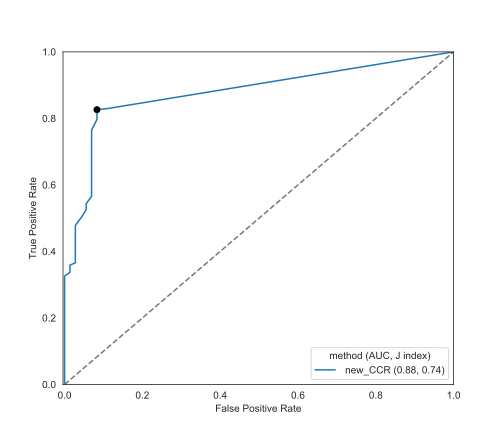

In [15]:
SVG('/Users/jasonkunisaki/Desktop/quinlan_lab_rotation/chr20/pathoscore_results/pathoscore.roc.svg') 